In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.7.1 anndata==0.7.5 umap==0.5.1 numpy==1.19.2 scipy==1.6.1 pandas==1.2.3 scikit-learn==0.24.1 statsmodels==0.12.2 python-igraph==0.9.0 leidenalg==0.8.3


In [3]:
results_file = 'write/pcs.h5ad'  # the file that will store the analysis results

In [ ]:
adata = sc.read_csv('perturb-cite-seq/RNA_expression.csv')

In [ ]:
adata = adata.transpose()

In [ ]:
adata

In [ ]:
adata.write('cache/pcs.h5ad', compression=<Empty.token: 0>)

normalizing counts per cell
    finished (0:02:16)


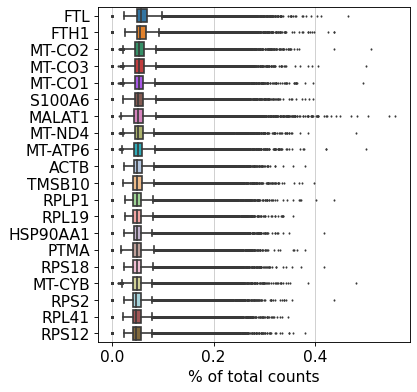

In [7]:
sc.pl.highest_expr_genes(adata, n_top=20, )

In [8]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=243)

filtered out 6937 genes that are detected in less than 243 cells


In [9]:
adata

AnnData object with n_obs × n_vars = 218331 × 16775
    obs: 'n_genes'
    var: 'n_cells'

In [10]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:09)


In [11]:
sc.pp.log1p(adata)

In [12]:
adata

AnnData object with n_obs × n_vars = 218331 × 16775
    obs: 'n_genes'
    var: 'n_cells'
    uns: 'log1p'

In [13]:
adata.raw = adata

In [15]:
sc.pp.scale(adata, max_value=10)

In [16]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    with n_comps=50
    finished (0:02:47)


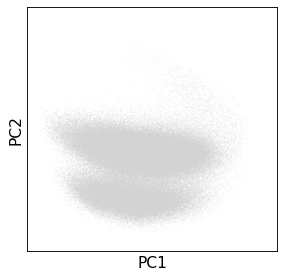

In [17]:
sc.pl.pca(adata)

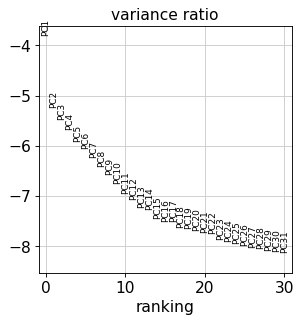

In [18]:
sc.pl.pca_variance_ratio(adata, log=True)

In [19]:
adata.write(results_file)

In [20]:
adata

AnnData object with n_obs × n_vars = 218331 × 16775
    obs: 'n_genes'
    var: 'n_cells', 'mean', 'std'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [21]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:36)


In [22]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:04:12)


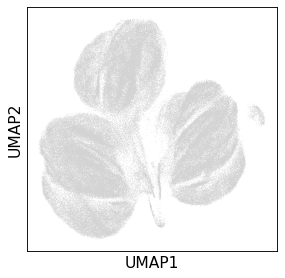

In [23]:
sc.pl.umap(adata)

In [24]:
sc.tl.leiden(adata)

running Leiden clustering
    finished: found 27 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:02:27)


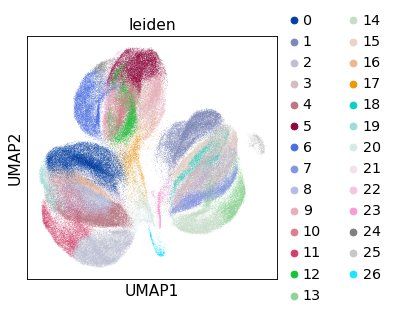

In [25]:
sc.pl.umap(adata, color='leiden')

In [26]:
adata.write(results_file)

In [27]:
df = pd.read_csv('perturb-cite-seq/RNA_metadata.csv')

/home/rishabhgupta/miniconda3/envs/scanpy/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [28]:
ptbs = df['sgRNA'].sort_values().unique()

In [29]:
conds = df[1:]['condition'].sort_values().unique() 

In [30]:
adata.obs.index

Index(['CELL_1', 'CELL_2', 'CELL_3', 'CELL_4', 'CELL_5', 'CELL_6', 'CELL_7',
       'CELL_8', 'CELL_9', 'CELL_10',
       ...
       'CELL_218322', 'CELL_218323', 'CELL_218324', 'CELL_218325',
       'CELL_218326', 'CELL_218327', 'CELL_218328', 'CELL_218329',
       'CELL_218330', 'CELL_218331'],
      dtype='object', length=218331)

In [31]:
df2 = df[df['NAME'].isin(adata.obs.index)]

In [32]:
adata.obs['sgRNA'] = df2['sgRNA'].values
adata.obs['condition'] = df2['condition'].values
# adata.obs = adata.obs.drop(['sgRNA'], axis=1)

In [33]:
adata.obs

,n_genes,leiden,sgRNA,condition
CELL_1,3520,6,HLA-B_2,Control
CELL_2,3531,6,NaN,Control
CELL_3,5541,5,HLA-B_2,Control
CELL_4,4086,12,NaN,Control
CELL_5,3178,17,NaN,Control
...,...,...,...,...
CELL_218327,3686,13,NaN,Co-culture
CELL_218328,3462,18,NaN,Co-culture
CELL_218329,3768,18,NaN,Co-culture
CELL_218330,4158,15,CDKN2B_3,Co-culture


... storing 'sgRNA' as categorical
... storing 'condition' as categorical


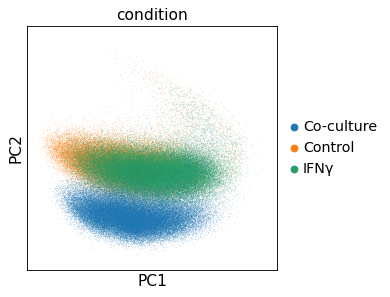

In [34]:
sc.pl.pca(adata, color='condition')

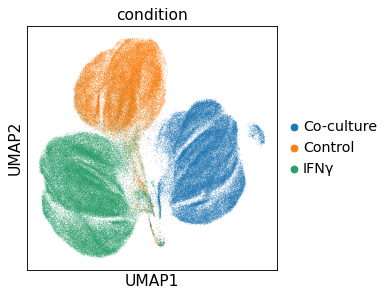

In [35]:
sc.pl.umap(adata, color=['condition'])

In [36]:
# counts = adata.obs[adata.obs['sgRNA'] != 'nan'].groupby('sgRNA').count()['condition']#.to_list()
counts = adata.obs.groupby('sgRNA').count()['condition']#.to_list()

In [37]:
np.mean(counts)

266.5824175824176

In [74]:
import torch
from geomloss import SamplesLoss
from IPython import embed
import ot
import time

loss = SamplesLoss(loss="sinkhorn", p=1, debias=False, scaling=0.9)

c = 'Control'
min_set_size = 50
# counts = []
# sets = []
ptbs_new = []
for p in ptbs:
    x = adata[(adata.obs['condition']==c) & (adata.obs['sgRNA'] == p), :]
    if x.shape[0] >= min_set_size:
        ptbs_new.append(p)
sink = np.zeros([len(conds),len(ptbs_new),len(ptbs_new)])
wass = np.zeros([len(conds),len(ptbs_new),len(ptbs_new)])
for c in range(len(conds)):
    for i in range(len(ptbs_new)):
        for j in range(i+1,len(ptbs_new)):
#             print(c,i,j)
#             x1 = torch.tensor(adata.obsm['X_pca'][(adata.obs['condition']==conds[c]) & (adata.obs['sgRNA'] == ptbs_new[i]), :])
            x1 = torch.tensor(adata.X[(adata.obs['condition']==conds[c]) & (adata.obs['sgRNA'] == ptbs_new[i]), :])
#             x2 = torch.tensor(adata.obsm['X_pca'][(adata.obs['condition']==conds[c]) & (adata.obs['sgRNA'] == ptbs_new[j]), :])
            x2 = torch.tensor(adata.X[(adata.obs['condition']==conds[c]) & (adata.obs['sgRNA'] == ptbs_new[j]), :])
            start = time.time()
            sink[c,i,j] = loss(x1, x2)
            sink[c,j,i] = sink[c,i,j]
            mid = time.time()
            a, b = np.ones((x1.shape[0],)) / x1.shape[0], np.ones((x2.shape[0],)) / x2.shape[0]
            M = ot.dist(x1, x2, metric='euclidean')
            wass[c,i,j] = ot.emd2(a,b,M)
            wass[c,j,i] = wass[c,i,j]
            end = time.time()
            break
        break
    break
    #         count = inp.shape[0]
        #     print(count)
    #         if count > 0:
    #             counts.append(count)
    #             ids = np.random.choice(count, set_size)
    #             sets.append(inp[ids])


In [75]:
print(mid-start, end-mid)

0.0783541202545166 0.10775518417358398


In [76]:
print(x1.shape, x2.shape)

torch.Size([79, 16775]) torch.Size([80, 16775])


/home/rishabhgupta/miniconda3/envs/scanpy/lib/python3.8/site-packages/umap/umap_.py:1735: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  warn(
/home/rishabhgupta/miniconda3/envs/scanpy/lib/python3.8/site-packages/umap/umap_.py:1735: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  warn(
/home/rishabhgupta/miniconda3/envs/scanpy/lib/python3.8/site-packages/umap/umap_.py:1735: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  warn(


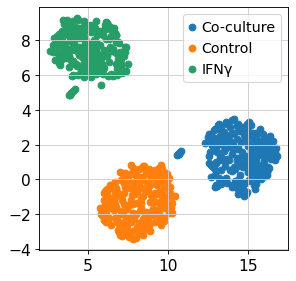

In [45]:
import matplotlib.pyplot as plt
import umap
umap_embedder = umap.UMAP(metric='precomputed')
for i in range(3):
    umap_embedding = umap_embedder.fit_transform(sink[i])
    plt.scatter(umap_embedding[:,0], umap_embedding[:,1], label=conds[i])
plt.legend()

# X_2d = umap_embedder.fit_transform(sink[:10,:10])
# target_ids = range(10)
# plt.figure(figsize=(6, 5))
# colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'brown', 'orange', 'purple'
# for i, c in zip(target_ids, colors):
#     plt.scatter(X_2d[i, 0], X_2d[i, 1], c=c, label=i)
# plt.legend()

/home/rishabhgupta/miniconda3/envs/scanpy/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(
/home/rishabhgupta/miniconda3/envs/scanpy/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(
/home/rishabhgupta/minic

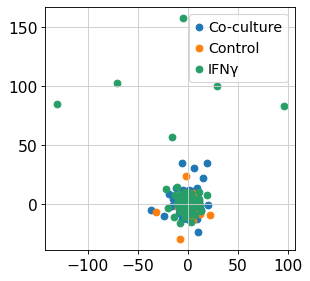

In [44]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, init='random', metric='precomputed')
for i in range(3):
    tsne_embedding = tsne.fit_transform(sink[i])
    plt.scatter(tsne_embedding[:,0], tsne_embedding[:,1], label=conds[i])
plt.legend()

In [ ]:
print(len(counts), min(counts), max(counts), np.mean(counts))